In [75]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Overview
In the methodology submission assignment, all data were standardized and normalized. Therefore, this time, appropriate data preprocessing methods will be executed for each feature based on the suitability of the data. The results will be judged based on the outcomes of k-means.

1. Remove one of the features that have a high correlation coefficient.
2. Look at `df.describe` to try the appropriate data preprocessing method based on the distribution of the data.

The purporse of this notebook is to improve the performance of k-means model.

## Load Data

In [76]:
from utils import get_df_description

# load df
df_train = pd.read_csv('../datasets/df_train.csv')
print(df_train.shape)

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df_train, description_json_df)
df_description

(96096, 26)


,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


In [77]:
## Selecting numeric columns
df_numeric = df_train.select_dtypes(include=['number']).dropna()
df_numeric = df_numeric.drop(columns=['customer_zip_code_prefix']) ## qualitative
print(df_numeric.shape)
df_numeric.head()

(92633, 13)


,frequency,repeater,recency,monetary,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used,customer_in_sao_paulo
0,1,0,160,141.90,0,141.90,1,1,-5.0,5.0,0.0,1,1
1,1,0,163,27.19,0,27.19,1,1,-5.0,4.0,0.0,1,1
2,1,0,585,86.22,1,86.22,1,1,-2.0,3.0,0.0,1,0
3,1,0,369,43.62,1,43.62,1,1,-12.0,4.0,0.0,1,0
4,1,0,336,196.89,1,196.89,1,1,-8.0,5.0,0.0,1,1


In [78]:
# We have rfm_score, so drop frequency and monetary. Also, drop fo_voucher_used because we have fo_voucher_amount
df_numeric = df_numeric.drop(columns=['frequency', 'monetary', 'fo_voucher_used'])

df = df_numeric.sample(n=5000, random_state=42)
df.describe()

,repeater,recency,rfm_score,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,customer_in_sao_paulo
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.035400,288.112200,0.543200,162.116268,0.896000,0.762800,-11.87700,4.129400,3.588004,0.416400
std,0.184807,152.101968,0.643597,234.092944,0.305291,0.425408,10.57797,1.302803,32.426098,0.493011
min,0.000000,49.000000,0.000000,13.780000,0.000000,0.000000,-75.00000,1.000000,0.000000,0.000000
25%,0.000000,164.750000,0.000000,62.597500,1.000000,1.000000,-17.00000,4.000000,0.000000,0.000000
50%,0.000000,271.000000,0.000000,105.490000,1.000000,1.000000,-12.00000,5.000000,0.000000,0.000000
75%,0.000000,397.000000,1.000000,179.340000,1.000000,1.000000,-7.00000,5.000000,0.000000,1.000000
max,1.000000,743.000000,3.000000,6929.310000,1.000000,1.000000,153.00000,5.000000,1201.080000,1.000000


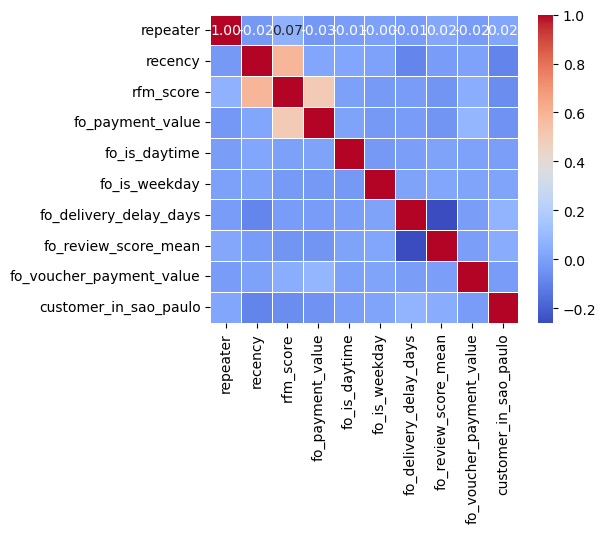

In [79]:
corr = df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

In [80]:
# Data preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from scipy.stats import yeojohnson

# Function to handle outliers through log transformation
def log_transform(x):
    return np.log1p(x)  # log1p computes log(x + 1) to ensure no negative values.

# Defining data preprocessing steps
preprocessing_steps = [
    ('log_transform', ['fo_payment_value', 'fo_voucher_payment_value']),
    ('standardize', ['recency', 'rfm_score', 'fo_delivery_delay_days', 'fo_review_score_mean']),
    ('robust_scale', ['fo_payment_value', 'fo_voucher_payment_value']),
    ('min_max_scale', ['fo_delivery_delay_days'])
]

# Creating a pipeline for applying preprocessing
preprocessors = ColumnTransformer(transformers=[
    ('log', FunctionTransformer(log_transform), ['fo_payment_value', 'fo_voucher_payment_value']),
    ('std', StandardScaler(), ['recency', 'rfm_score', 'fo_delivery_delay_days', 'fo_review_score_mean']),
    ('robust', RobustScaler(), ['fo_payment_value', 'fo_voucher_payment_value']),
    ('min_max', MinMaxScaler(), ['fo_delivery_delay_days'])
])

# Applying the pipeline to the DataFrame
df_transformed = preprocessors.fit_transform(df)

# Converting the transformed data back into a DataFrame (since ColumnTransformer returns a Numpy array)
df_transformed = pd.DataFrame(df_transformed, columns=[
    'fo_payment_value_log', 'fo_voucher_payment_value_log',  # Features after log transformation
    'recency_std', 'rfm_score_std', 'fo_delivery_delay_days_std', 'fo_review_score_mean_std',  # Features after standardization
    'fo_payment_value_robust', 'fo_voucher_payment_value_robust',  # Features after robust scaling
    'fo_delivery_delay_days_min_max'  # Features after MinMax scaling
])

# Apply the Yeo-Johnson transformation to 'fo_delivery_delay_days'
df_transformed['fo_delivery_delay_days_yj'], _ = yeojohnson(df['fo_delivery_delay_days'])


# Print the skewness of the transformed features
print(df_transformed.skew())
df_transformed.describe()


fo_payment_value_log                0.573289
fo_voucher_payment_value_log        5.303188
recency_std                         0.434739
rfm_score_std                       0.935514
fo_delivery_delay_days_std          2.214884
fo_review_score_mean_std           -1.433642
fo_payment_value_robust             9.898727
fo_voucher_payment_value_robust    23.336440
fo_delivery_delay_days_min_max      2.214884
fo_delivery_delay_days_yj          -0.641983
dtype: float64


,fo_payment_value_log,fo_voucher_payment_value_log,recency_std,rfm_score_std,fo_delivery_delay_days_std,fo_review_score_mean_std,fo_payment_value_robust,fo_voucher_payment_value_robust,fo_delivery_delay_days_min_max,fo_delivery_delay_days_yj
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.710430,0.151829,1.755041e-16,-1.847411e-17,8.171241e-17,-3.190337e-16,0.485053,3.588004,0.276855,-17.256998
std,0.801026,0.799912,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,2.005208,32.426098,0.046395,13.825700
min,2.693275,0.000000,-1.572209e+00,-8.440913e-01,-5.967999e+00,-2.402292e+00,-0.785575,0.000000,0.000000,-132.175008
25%,4.152574,0.000000,-8.111305e-01,-8.440913e-01,-4.843569e-01,-9.933425e-02,-0.367411,0.000000,0.254386,-24.004772
50%,4.668051,0.000000,-1.125160e-01,-8.440913e-01,-1.162910e-02,6.683184e-01,0.000000,0.000000,0.276316,-16.162618
75%,5.194844,0.000000,7.159585e-01,7.098323e-01,4.610987e-01,6.683184e-01,0.632589,0.000000,0.298246,-8.812214
max,8.843660,7.091809,2.990976e+00,3.817680e+00,1.558839e+01,6.683184e-01,58.451892,1201.080000,1.000000,79.312186


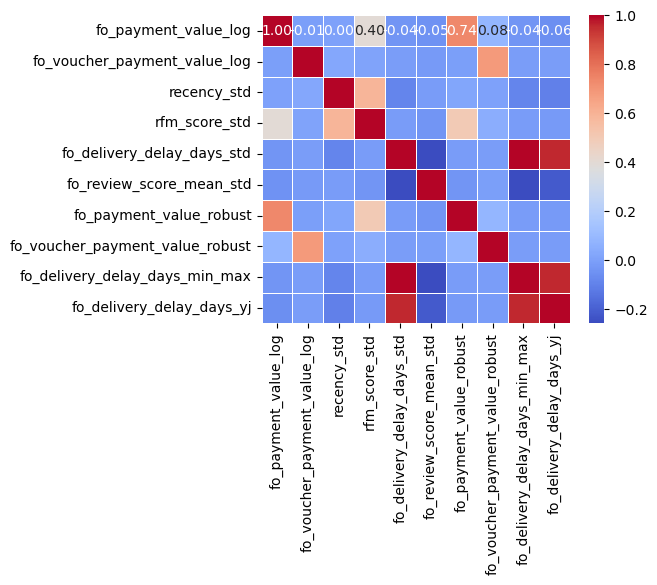

In [81]:
corr = df_transformed.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.show()

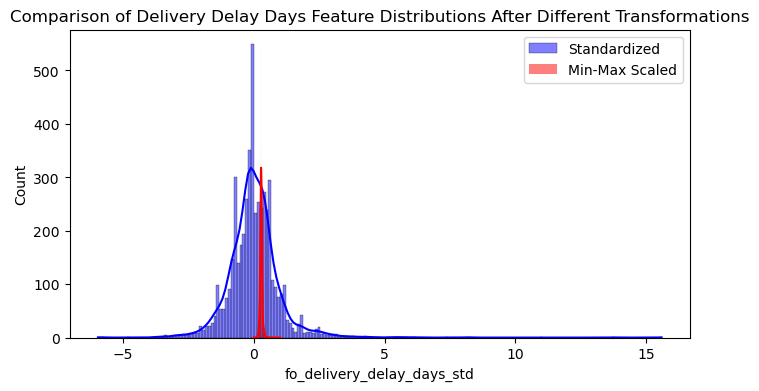

In [82]:
# we have 2 pairs taking the difference approcches but the original feature is the same.
# (recency_min_max, recency_std) and (fo_delivery_days_std, fo_delivery_days_min_max)

# delivery_delay_days
plt.figure(figsize=(8, 4))
sns.histplot(df_transformed['fo_delivery_delay_days_std'], kde=True, color='blue', label='Standardized')
sns.histplot(df_transformed['fo_delivery_delay_days_min_max'], kde=True, color='red', label='Min-Max Scaled')
plt.legend()
plt.title('Comparison of Delivery Delay Days Feature Distributions After Different Transformations')
plt.show()

## k-means

In [83]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    dbi_scores = []
    for n_clusters in range(2, max_clusters + 1):  # Starting from 2 as there can't be 1 cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        s_score = silhouette_score(data, labels)
        dbi_score = davies_bouldin_score(data, labels)
        silhouette_scores.append(s_score)
        dbi_scores.append(dbi_score)
        print(n_clusters, s_score, dbi_score)

    # Returning all silhouette and DBI scores
    return silhouette_scores, dbi_scores

2 0.9821718204162884 0.01996315205970836
3 0.8789712667418539 0.3612386883298215
4 0.45756919802799684 0.535697304330303
5 0.4889476657075381 0.5587620433993983
6 0.4628874600808278 0.5206341775144053
7 0.4452399390092487 0.5393249022607948
8 0.43972974519736446 0.55159723030621
9 0.44566717990677934 0.5535519398377057
10 0.4422271037650213 0.5610170771940568


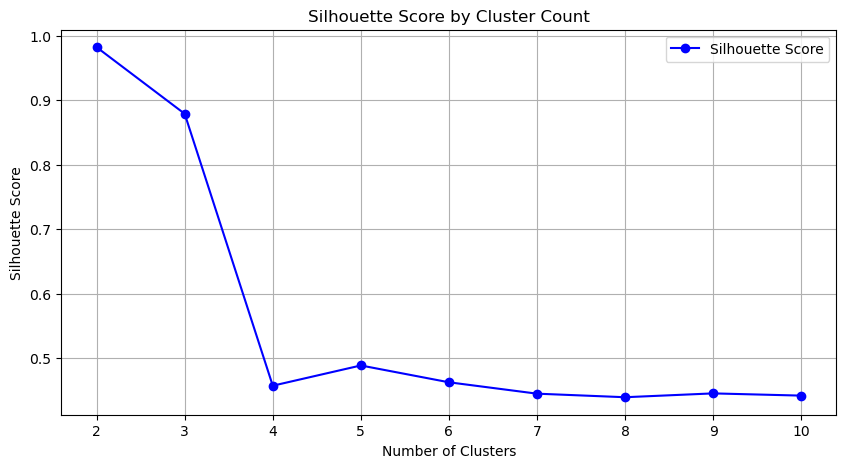

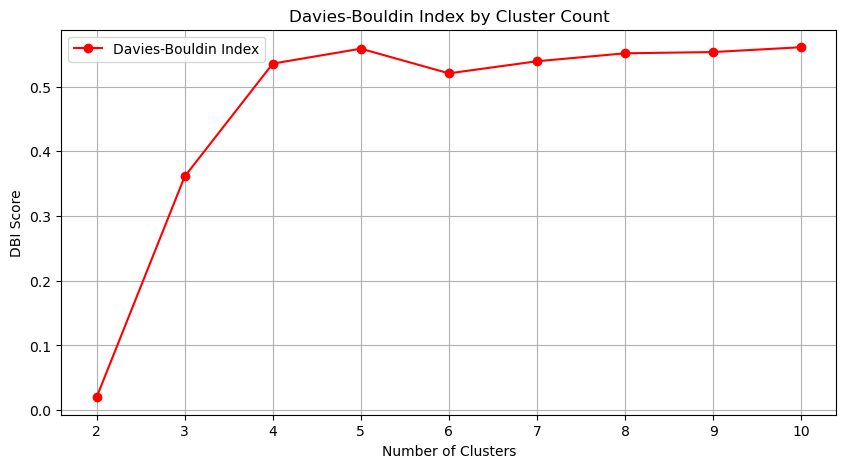

In [84]:
silhouette_scores, dbi_scores = find_optimal_clusters(df_transformed, max_clusters=10)

clusters_range = range(2, 11)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
plt.title('Silhouette Score by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(clusters_range, dbi_scores, marker='o', linestyle='-', color='red', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index by Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.xticks(clusters_range)
plt.legend()
plt.grid(True)

plt.show()